<div align='center'><strong>Wikipedia Pageviews Project</strong>
<br />
<i>Netanel Madmoni</i>
</div>

----------------

# Introduction

In [1]:
#imports
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import seaborn as sns
from rich import print
from IPython.display import Image

load_dotenv()

RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PROCESSED_DATA_DIR = Path(os.getenv('PROCESSED_DATA_DIR'))

# Raw Data Acquisition

1. Get List of people on Wikipedia
```sql
SELECT DISTINCT en_wiki -- page title name in english wikipedia	
FROM  `rising-theater-416315.wikipedia_pageviews.wikidata`,
      UNNEST(instance_of) AS instance_of_struct

    
WHERE instance_of_struct.numeric_id = 5 -- instance_of = 5 => person
```

2. Get pagevoew data for those people

      ```sql
      SELECT title, DATETIME_TRUNC(datehour, MONTH) AS month, SUM(views) AS monthly_views

                  
      FROM  `rising-theater-416315.wikipedia_pageviews.pageviews_2023` a
            JOIN `rising-theater-416315.data_for_project.distinct_people` b
            ON a.title = b.en_wiki

      
      WHERE datehour IS NOT NULL
      AND wiki = "en"

      GROUP BY title, DATETIME_TRUNC(datehour, MONTH)
      ```

3. Get wikidata for those people
      ```sql
      SELECT *	
      FROM  `rising-theater-416315.wikipedia_pageviews.wikidata`,
      UNNEST(instance_of) AS instance_of_struct

    
      WHERE instance_of_struct.numeric_id = 5
      ```

# Data transformation

## Views Data

Are organized in csv files, one per year.

In [6]:
# Read raw data
dfs = []
for file in RAW_DATA_DIR.glob(r'monthly_views_*.csv'):
    print(f'{file.name} - {os.stat(file).st_size / 1024 ** 2:.2f} MB)')
    dfs.append(pl.read_csv(file))

print(f'Total files: {len(dfs)}')

monthly_views_2015.csv - 411.06 MB)
monthly_views_2016.csv - 658.91 MB)
monthly_views_2019.csv - 803.42 MB)
monthly_views_2020.csv - 851.54 MB)
monthly_views_2017.csv - 708.39 MB)
monthly_views_2022.csv - 949.62 MB)
monthly_views_2023.csv - 980.47 MB)
monthly_views_2021.csv - 904.32 MB)
monthly_views_2018.csv - 755.98 MB)
Total files: 0


In [3]:
try:
    views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')
except FileNotFoundError:
    # Pivot
    transformed_dfs = []
    for df in tqdm(dfs):
        transformed_df = (df.with_columns(pl.col('month')
                                        .map_elements(lambda s: f'{s[:4]}-{s[5:7]}')
                                        .alias('year_month'))
                        .pivot(index='title', columns='year_month', values='monthly_views')
        )
        transformed_dfs.append(transformed_df)
    # Join
    all_names = pl.concat([df.select('title') for df in dfs]).unique()
    print(f'{len(all_names):,}')
    views_df = all_names
    for i, df in tqdm(enumerate(transformed_dfs)):
        views_df = df.join(views_df, 'title', 'outer_coalesce')
    views_df = views_df.select(['title', *sorted([c for c in views_df.columns if c != 'title'])])
    views_df.write_parquet(f'{PROCESSED_DATA_DIR}/pageviews_all.parquet')

views_df

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


### Additional Features Extraction

## Entity Data

### Reading the Data

Are organized in json files.

In [2]:
info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
len(list(info_files))

400

For example...

In [86]:
info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
with open(next(info_files)) as f:
    for line in f:
        d = json.loads(line)
        sites = [sitelink['site'] for sitelink in d['sitelinks']]
        if 'enwiki' in sites:
            print(d)
            break
    

{
    'id': 'Q17122148',
    'numeric_id': '17122148',
    'en_label': 'Albrecht Joseph',
    'en_wiki': 'Albrecht_Joseph',
    'en_description': 'German screenwriter, film editor and author',
    'type': 'item',
    'sitelinks': [
        {'site': 'dewiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'enwiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'frwiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'arwiki', 'title': 'ألبرشت جوزيف', 'encoded': 'ألبرشت_جوزيف'},
        {'site': 'arzwiki', 'title': 'البرشت چوزيف', 'encoded': 'البرشت_چوزيف'},
        {'site': 'fawiki', 'title': 'آلبرشت یوزف', 'encoded': 'آلبرشت_یوزف'}
    ],
    'descriptions': [
        {'language': 'de', 'value': 'deutsch-amerikanischer Theater- und Filmschaffender'},
        {'language': 'fa', 'value': 'فیلمنامه\u200cنویس، تدوینگر، و نویسنده آلمانی'},
        {'language': 'en', 'value': 'German screenwriter, film editor and author'},
        {'language': 'nl', 'value': 'Duits scenarioschrijver (1901-1991)'},
        {'language': 'sv', 'value': 'tysk författare och filmklippare'}
    ],
    'labels': [
        {'language': 'de', 'value': 'Albrecht Joseph'},
        {'language': 'fr', 'value': 'Albrecht Joseph'},
        {'language': 'nl', 'value': 'Albrecht Joseph'},
        {'language': 'en', 'value': 'Albrecht Joseph'},
        {'language': 'es', 'value': 'Albrecht Joseph'},
        {'language': 'hu', 'value': 'Albrecht Joseph'},
        {'language': 'sl', 'value': 'Albrecht Joseph'},
        {'language': 'ca', 'value': 'Albrecht Joseph'},
        {'language': 'ast', 'value': 'Albrecht Joseph'},
        {'language': 'ar', 'value': 'ألبرشت جوزيف'},
        {'language': 'cs', 'value': 'Albrecht Joseph'},
        {'language': 'sk', 'value': 'Albrecht Joseph'},
        {'language': 'arz', 'value': 'البرشت چوزيف'},
        {'language': 'it', 'value': 'Albrecht Joseph'},
        {'language': 'sq', 'value': 'Albrecht Joseph'},
        {'language': 'he', 'value': "אלברכט ג'וזף"},
        {'language': 'sv', 'value': 'Albrecht Joseph'},
        {'language': 'ga', 'value': 'Albrecht Joseph'},
        {'language': 'fa', 'value': 'آلبرشت یوزف'},
        {'language': 'ru', 'value': 'Элбрехт Джозеф'}
    ],
    'aliases': [
        {'language': 'de', 'value': 'Al Joseph'},
        {'language': 'en', 'value': 'Al Joseph'},
        {'language': 'cs', 'value': 'Al Joseph'},
        {'language': 'sk', 'value': 'Al Joseph'}
    ],
    'instance_of': [{'numeric_id': '5'}],
    'gender': [{'numeric_id': '6581097'}],
    'date_of_birth': [{'time': '+1901-11-20T00:00:00Z'}],
    'date_of_death': [{'time': '+1901-11-20T00:00:00Z'}],
    'worked_at': [],
    'country_of_citizenship': [{'numeric_id': '183'}],
    'country': [],
    'educated_at': [],
    'occupation': [{'numeric_id': '28389'}, {'numeric_id': '7042855'}, {'numeric_id': '36180'}],
    'instrument': [],
    'genre': [],
    'industry': [],
    'subclass_of': [],
    'coordinate_location': [],
    'iso_3166_alpha3': [],
    'member_of': [],
    'from_fictional_universe': []
}

In [3]:
try:
    info_df = pl.read_parquet(PROCESSED_DATA_DIR / 'wikidata_all.parquet')
except FileNotFoundError:
    info_list = []
    info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
    for file in info_files:
        with open(file) as f:
            for line in f:
                d = json.loads(line)
                sites = [sitelink['site'] for sitelink in d['sitelinks']]
                if 'enwiki' in sites:
                    info_list.append(d)
    info_df = pl.DataFrame(info_list)
    
info_df.head()

id,numeric_id,en_label,en_wiki,en_description,type,sitelinks,descriptions,labels,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,iso_3166_alpha3,member_of,from_fictional_universe
str,str,str,str,str,str,list[struct[3]],list[struct[2]],list[struct[2]],list[struct[2]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[2]],list[null],list[struct[1]],list[struct[1]]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""item""","[{""dewiki"",""Albrecht Joseph"",""Albrecht_Joseph""}, {""enwiki"",""Albrecht Joseph"",""Albrecht_Joseph""}, … {""fawiki"",""آلبرشت یوزف"",""آلبرشت_یوزف""}]","[{""de"",""deutsch-amerikanischer Theater- und Filmschaffender""}, {""fa"",""فیلمنامه‌نویس، تدوینگر، و نویسنده آلمانی""}, … {""sv"",""tysk författare och filmklippare""}]","[{""de"",""Albrecht Joseph""}, {""fr"",""Albrecht Joseph""}, … {""ru"",""Элбрехт Джозеф""}]","[{""de"",""Al Joseph""}, {""en"",""Al Joseph""}, … {""sk"",""Al Joseph""}]","[{""5""}]","[{""6581097""}]","[{""+1901-11-20T00:00:00Z""}]","[{""+1901-11-20T00:00:00Z""}]",[],"[{""183""}]",[],[],"[{""28389""}, {""7042855""}, {""36180""}]",[],[],[],[],[],[],[],[]
"""Q100707809""","""100707809""","""Robert Cahaly""","""Robert_Cahaly""","""American polls…","""item""","[{""enwiki"",""Robert Cahaly"",""Robert_Cahaly""}, {""jawiki"",""ロバート・カヘリー"",""ロバート・カヘリー""}]","[{""en"",""American pollster and political consultant""}, {""zh"",""美国民调专家""}]","[{""en"",""Robert Cahaly""}, {""de"",""Robert Cahaly""}, … {""pt-br"",""Robert Cahaly""}]",[],"[{""5""}]","[{""6581097""}]",[],[],"[{""100704905""}]","[{""30""}]",[],"[{""1024426""}]","[{""16919156""}, {""8125919""}]",[],[],[],[],[],[],[],[]
"""Q8988407""","""8988407""","""Li Fei""","""Lei_Fei""","""actor, busines…","""item""","[{""zhwiki"",""李菲"",""李菲""}, {""enwiki"",""Lei Fei"",""Lei_Fei""}]","[{""nl"",""ondernemer""}, {""en"",""actor, businesswoman, and wushu taolu athlete from Macau""}]","[{""zh"",""李菲""}, {""en"",""Li Fei""}, … {""sq"",""Jewel Lee""}]","[{""en"",""Jewel Lee""}]","[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],"[{""43845""}]",[],[],[],[],[],[],[],[]
"""Q3588237""","""3588237""","""Yang Ti-liang""","""Yang_Ti-liang""","""Hong Kong judg…","""item""","[{""enwiki"",""Yang Ti-liang"",""Yang_Ti-liang""}, {""zhwiki"",""楊鐵樑"",""楊鐵樑""}, … {""kowiki"",""양톄량"",""양톄량""}]","[{""en"",""Hong Kong judge (1929–2023)""}, {""nl"",""rechter uit Brunei""}, … {""ko"",""홍콩의 판사 (1929–2023)""}]","[{""en"",""Yang Ti-liang""}, {""en-ca"",""Yang Ti-liang""}, … {""pap"",""Yang Ti-liang""}]","[{""en"",""Sir Ti-liang Yang""}, {""ko"",""양티량""}, {""ko"",""양철량""}]","[{""5""}]","[{""6581097""}]","[{""+1929-06-30T00:00:00Z""}]","[{""+1929-06-30T00:00:00Z""}]",[],"[{""148""}]",[],"[{""1639978""}, {""193196""}]","[{""16533""}, {""329455""}, {""82955""}]",[],[],[],[],[],[],"[{""157412""}]",[]
"""Q521785""","""521785""","""Mauro Sérgio V…","""Maurinho_(foot…","""Brazilian foot…","""item""","[{""itwiki"",""Mauro Sérgio Viriato Mendes"",""Mauro_Sérgio_Viriato_Mendes""}, {""plwiki"",""Mauro Sérgio Viriato Mendes"",""Mauro_Sérgio_Viriato_Mendes""}, … {""trwiki"",""Maurinho (1978 doğumlu futbolcu)"",""Maurinho_(1978_doğumlu_futbolcu)""}]","[{""it"",""calciatore brasiliano""}, {""fr"",""joueur de football brésilien""}, … {""mos"",""Bal tãongra""}]","[{""it"",""Mauro Sérgio Viriato Mendes""}, {""en"",""Mauro Sérgio Viriato Mendes""}, … {""tr"",""Maurinho (1978 doğumlu futbolcu)""}]","[{""es"",""Mauro Sergio Viriato Mendes""}, {""es"",""Maurinho""}, … {""fr"",""Maurinho""}]","[{""5""}]","[{""6581097""}]","[{""+1978-10-11T00:00:00Z""}]","[{""+1978-10-11T00:00:00Z""}]",[],"[{""155""}]",[],[],"[{""937857""}]",[],[],[],[],[],[],[],[]


### Cleaning the Data

Let's look at the columns and their data types.

In [3]:
print(dict(zip(info_df.columns, info_df.dtypes)))

{
    'id': String,
    'numeric_id': String,
    'en_label': String,
    'en_wiki': String,
    'en_description': String,
    'type': String,
    'sitelinks': List(Struct({'site': String, 'title': String, 'encoded': String})),
    'descriptions': List(Struct({'language': String, 'value': String})),
    'labels': List(Struct({'language': String, 'value': String})),
    'aliases': List(Struct({'language': String, 'value': String})),
    'instance_of': List(Struct({'numeric_id': String})),
    'gender': List(Struct({'numeric_id': String})),
    'date_of_birth': List(Struct({'time': String})),
    'date_of_death': List(Struct({'time': String})),
    'worked_at': List(Struct({'numeric_id': String})),
    'country_of_citizenship': List(Struct({'numeric_id': String})),
    'country': List(Struct({'numeric_id': String})),
    'educated_at': List(Struct({'numeric_id': String})),
    'occupation': List(Struct({'numeric_id': String})),
    'instrument': List(Struct({'numeric_id': String})),
    'genre': List(Struct({'numeric_id': String})),
    'industry': List(Struct({'numeric_id': String})),
    'subclass_of': List(Struct({'numeric_id': String})),
    'coordinate_location': List(Struct({'latitude': Float64, 'longitude': Float64})),
    'iso_3166_alpha3': List(Null),
    'member_of': List(Struct({'numeric_id': String})),
    'from_fictional_universe': List(Struct({'numeric_id': String}))
}

**Questions for cleaning the data**
1. General questions about the dataframe:
    1. Are there any duplicate rows?
    1. Are there any columns that contain nothing but empty lists or null values? Are there columns that are *mostly* empty?
    1. Are there any list/struct columns that always contain a single value (= lists that can be flattened)?
    1. How many unique values does each column contains?
2. Column-specific questions:
    1. Can `en_wiki` be a primary key instead of the id columns, in order to match this table to the pageviews one?
    1. Can an entity have more than one `gender`? Can an entity have no `gender`? If so - why?

---

* **Duplicate rows**

In [4]:
duplicated_df = info_df.filter(info_df['id'].is_duplicated()).sort('id')

print(f'There are {duplicated_df.height} rows carrying duplicate `id`s.')

There are 22 rows carrying duplicate `id`s.

In [8]:
(duplicated_df == duplicated_df.shift(-1))[::2].to_numpy().all()

True

In [36]:
info_df.filter(info_df['id'].is_duplicated()).sort('id').write_json(PROCESSED_DATA_DIR / 'duplicates.json')

thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-core/src/serde/series.rs:74:17:
not implemented for dtype Null


PanicException: not implemented for dtype Null

In [51]:
print(info_df['en_wiki'].n_unique(), info_df.height)

1993447 1993459

In [7]:
# For each list column, view distribution of list lengths 
list_columns = [c for c in info_df.columns if info_df[c].dtype == pl.List]
for column in list_columns:
    print(column, info_df[column].map_elements(len).value_counts().sort(column).rename({column: f'length of {column}'}))

sitelinks shape: (260, 2)
┌─────────────────────┬────────┐
│ length of sitelinks ┆ count  │
│ ---                 ┆ ---    │
│ i64                 ┆ u32    │
╞═════════════════════╪════════╡
│ 1                   ┆ 477554 │
│ 2                   ┆ 364181 │
│ 3                   ┆ 281088 │
│ 4                   ┆ 196451 │
│ 5                   ┆ 140116 │
│ …                   ┆ …      │
│ 304                 ┆ 1      │
│ 306                 ┆ 1      │
│ 310                 ┆ 1      │
│ 322                 ┆ 1      │
│ 325                 ┆ 1      │
└─────────────────────┴────────┘

descriptions shape: (131, 2)
┌────────────────────────┬────────┐
│ length of descriptions ┆ count  │
│ ---                    ┆ ---    │
│ i64                    ┆ u32    │
╞════════════════════════╪════════╡
│ 0                      ┆ 24897  │
│ 1                      ┆ 161926 │
│ 2                      ┆ 153203 │
│ 3                      ┆ 111702 │
│ 4                      ┆ 100204 │
│ …                      ┆ …      │
│ 138                    ┆ 1      │
│ 145                    ┆ 1      │
│ 157                    ┆ 1      │
│ 247                    ┆ 1      │
│ 444                    ┆ 1      │
└────────────────────────┴────────┘

labels shape: (290, 2)
┌──────────────────┬───────┐
│ length of labels ┆ count │
│ ---              ┆ ---   │
│ i64              ┆ u32   │
╞══════════════════╪═══════╡
│ 0                ┆ 5     │
│ 1                ┆ 26161 │
│ 2                ┆ 23938 │
│ 3                ┆ 28898 │
│ 4                ┆ 50694 │
│ …                ┆ …     │
│ 354              ┆ 1     │
│ 376              ┆ 4     │
│ 406              ┆ 2     │
│ 413              ┆ 23    │
│ 444              ┆ 1     │
└──────────────────┴───────┘

aliases shape: (412, 2)
┌───────────────────┬────────┐
│ length of aliases ┆ count  │
│ ---               ┆ ---    │
│ i64               ┆ u32    │
╞═══════════════════╪════════╡
│ 0                 ┆ 875131 │
│ 1                 ┆ 410386 │
│ 2                 ┆ 188971 │
│ 3                 ┆ 117841 │
│ 4                 ┆ 81822  │
│ …                 ┆ …      │
│ 1071              ┆ 2      │
│ 1072              ┆ 2      │
│ 1280              ┆ 1      │
│ 2356              ┆ 1      │
│ 2989              ┆ 1      │
└───────────────────┴────────┘

instance_of shape: (6, 2)
┌───────────────────────┬─────────┐
│ length of instance_of ┆ count   │
│ ---                   ┆ ---     │
│ i64                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ 1                     ┆ 1992244 │
│ 2                     ┆ 1118    │
│ 3                     ┆ 81      │
│ 4                     ┆ 13      │
│ 5                     ┆ 2       │
│ 11                    ┆ 1       │
└───────────────────────┴─────────┘

gender shape: (5, 2)
┌──────────────────┬─────────┐
│ length of gender ┆ count   │
│ ---              ┆ ---     │
│ i64              ┆ u32     │
╞══════════════════╪═════════╡
│ 0                ┆ 302     │
│ 1                ┆ 1992615 │
│ 2                ┆ 524     │
│ 3                ┆ 15      │
│ 4                ┆ 3       │
└──────────────────┴─────────┘

date_of_birth shape: (13, 2)
┌─────────────────────────┬─────────┐
│ length of date_of_birth ┆ count   │
│ ---                     ┆ ---     │
│ i64                     ┆ u32     │
╞═════════════════════════╪═════════╡
│ 0                       ┆ 197057  │
│ 1                       ┆ 1717118 │
│ 2                       ┆ 75153   │
│ 3                       ┆ 3645    │
│ 4                       ┆ 380     │
│ …                       ┆ …       │
│ 8                       ┆ 5       │
│ 9                       ┆ 2       │
│ 10                      ┆ 1       │
│ 11                      ┆ 1       │
│ 14                      ┆ 1       │
└─────────────────────────┴─────────┘

date_of_death shape: (13, 2)
┌─────────────────────────┬─────────┐
│ length of date_of_death ┆ count   │
│ ---                     ┆ ---     │
│ i64                     ┆ u32     │
╞═════════════════════════╪═════════╡
│ 0                       ┆ 197057  │
│ 1                       ┆ 1717118 │
│ 2                       ┆ 75153   │
│ 3                       ┆ 3645    │
│ 4                       ┆ 380     │
│ …                       ┆ …       │
│ 8                       ┆ 5       │
│ 9                       ┆ 2       │
│ 10                      ┆ 1       │
│ 11                      ┆ 1       │
│ 14                      ┆ 1       │
└─────────────────────────┴─────────┘

worked_at shape: (26, 2)
┌─────────────────────┬─────────┐
│ length of worked_at ┆ count   │
│ ---                 ┆ ---     │
│ i64                 ┆ u32     │
╞═════════════════════╪═════════╡
│ 0                   ┆ 1811046 │
│ 1                   ┆ 124410  │
│ 2                   ┆ 33005   │
│ 3                   ┆ 13518   │
│ 4                   ┆ 5988    │
│ …                   ┆ …       │
│ 21                  ┆ 2       │
│ 22                  ┆ 1       │
│ 23                  ┆ 1       │
│ 24                  ┆ 2       │
│ 27                  ┆ 1       │
└─────────────────────┴─────────┘

country_of_citizenship shape: (11, 2)
┌──────────────────────────────────┬─────────┐
│ length of country_of_citizenship ┆ count   │
│ ---                              ┆ ---     │
│ i64                              ┆ u32     │
╞══════════════════════════════════╪═════════╡
│ 0                                ┆ 448291  │
│ 1                                ┆ 1403337 │
│ 2                                ┆ 119595  │
│ 3                                ┆ 19666   │
│ 4                                ┆ 2025    │
│ …                                ┆ …       │
│ 6                                ┆ 111     │
│ 7                                ┆ 39      │
│ 8                                ┆ 8       │
│ 9                                ┆ 3       │
│ 10                               ┆ 1       │
└──────────────────────────────────┴─────────┘

country shape: (4, 2)
┌───────────────────┬─────────┐
│ length of country ┆ count   │
│ ---               ┆ ---     │
│ i64               ┆ u32     │
╞═══════════════════╪═════════╡
│ 0                 ┆ 1992220 │
│ 1                 ┆ 1235    │
│ 2                 ┆ 3       │
│ 3                 ┆ 1       │
└───────────────────┴─────────┘

educated_at shape: (15, 2)
┌───────────────────────┬─────────┐
│ length of educated_at ┆ count   │
│ ---                   ┆ ---     │
│ i64                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ 0                     ┆ 1332664 │
│ 1                     ┆ 411639  │
│ 2                     ┆ 174299  │
│ 3                     ┆ 54981   │
│ 4                     ┆ 14746   │
│ …                     ┆ …       │
│ 10                    ┆ 3       │
│ 11                    ┆ 6       │
│ 12                    ┆ 1       │
│ 13                    ┆ 1       │
│ 14                    ┆ 1       │
└───────────────────────┴─────────┘

occupation shape: (29, 2)
┌──────────────────────┬─────────┐
│ length of occupation ┆ count   │
│ ---                  ┆ ---     │
│ i64                  ┆ u32     │
╞══════════════════════╪═════════╡
│ 0                    ┆ 132087  │
│ 1                    ┆ 1196049 │
│ 2                    ┆ 383634  │
│ 3                    ┆ 154667  │
│ 4                    ┆ 67268   │
│ …                    ┆ …       │
│ 24                   ┆ 1       │
│ 25                   ┆ 1       │
│ 26                   ┆ 1       │
│ 31                   ┆ 1       │
│ 34                   ┆ 1       │
└──────────────────────┴─────────┘

instrument shape: (21, 2)
┌──────────────────────┬─────────┐
│ length of instrument ┆ count   │
│ ---                  ┆ ---     │
│ i64                  ┆ u32     │
╞══════════════════════╪═════════╡
│ 0                    ┆ 1904085 │
│ 1                    ┆ 73714   │
│ 2                    ┆ 11716   │
│ 3                    ┆ 2379    │
│ 4                    ┆ 858     │
│ …                    ┆ …       │
│ 18                   ┆ 2       │
│ 20                   ┆ 1       │
│ 24                   ┆ 1       │
│ 28                   ┆ 1       │
│ 31                   ┆ 1       │
└──────────────────────┴─────────┘

genre shape: (24, 2)
┌─────────────────┬─────────┐
│ length of genre ┆ count   │
│ ---             ┆ ---     │
│ i64             ┆ u32     │
╞═════════════════╪═════════╡
│ 0               ┆ 1918168 │
│ 1               ┆ 59963   │
│ 2               ┆ 8626    │
│ 3               ┆ 3208    │
│ 4               ┆ 1583    │
│ …               ┆ …       │
│ 19              ┆ 1       │
│ 20              ┆ 3       │
│ 21              ┆ 1       │
│ 23              ┆ 2       │
│ 25              ┆ 1       │
└─────────────────┴─────────┘

industry shape: (5, 2)
┌────────────────────┬─────────┐
│ length of industry ┆ count   │
│ ---                ┆ ---     │
│ i64                ┆ u32     │
╞════════════════════╪═════════╡
│ 0                  ┆ 1993093 │
│ 1                  ┆ 199     │
│ 2                  ┆ 67      │
│ 3                  ┆ 98      │
│ 4                  ┆ 2       │
└────────────────────┴─────────┘

subclass_of shape: (3, 2)
┌───────────────────────┬─────────┐
│ length of subclass_of ┆ count   │
│ ---                   ┆ ---     │
│ i64                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ 0                     ┆ 1993442 │
│ 1                     ┆ 16      │
│ 2                     ┆ 1       │
└───────────────────────┴─────────┘

coordinate_location shape: (3, 2)
┌───────────────────────────────┬─────────┐
│ length of coordinate_location ┆ count   │
│ ---                           ┆ ---     │
│ i64                           ┆ u32     │
╞═══════════════════════════════╪═════════╡
│ 0                             ┆ 1993434 │
│ 1                             ┆ 24      │
│ 2                             ┆ 1       │
└───────────────────────────────┴─────────┘

iso_3166_alpha3 shape: (1, 2)
┌───────────────────────────┬─────────┐
│ length of iso_3166_alpha3 ┆ count   │
│ ---                       ┆ ---     │
│ i64                       ┆ u32     │
╞═══════════════════════════╪═════════╡
│ 0                         ┆ 1993459 │
└───────────────────────────┴─────────┘

member_of shape: (26, 2)
┌─────────────────────┬─────────┐
│ length of member_of ┆ count   │
│ ---                 ┆ ---     │
│ i64                 ┆ u32     │
╞═════════════════════╪═════════╡
│ 0                   ┆ 1882253 │
│ 1                   ┆ 76594   │
│ 2                   ┆ 19466   │
│ 3                   ┆ 7629    │
│ 4                   ┆ 3423    │
│ …                   ┆ …       │
│ 21                  ┆ 4       │
│ 22                  ┆ 3       │
│ 23                  ┆ 2       │
│ 29                  ┆ 1       │
│ 31                  ┆ 1       │
└─────────────────────┴─────────┘

from_fictional_universe shape: (2, 2)
┌───────────────────────────────────┬─────────┐
│ length of from_fictional_univers… ┆ count   │
│ ---                               ┆ ---     │
│ i64                               ┆ u32     │
╞═══════════════════════════════════╪═════════╡
│ 0                                 ┆ 1993454 │
│ 1                                 ┆ 5       │
└───────────────────────────────────┴─────────┘

In [16]:
unique_value_counts = []
for column in list_columns:
    unique_value_counts.append((column, info_df[column].list.explode().n_unique()))
for column in [c for c in info_df.columns if c not in list_columns]:
    unique_value_counts.append((column, info_df[column].n_unique()))
    

pd.DataFrame(unique_value_counts, columns=['column', 'unique_values']).style.format('{:,}', subset='unique_values')

,column,unique_values
0,sitelinks,"10,497,927"
1,descriptions,"3,324,933"
2,labels,"34,576,620"
3,aliases,"5,870,043"
4,instance_of,357
5,gender,45
6,date_of_birth,"121,394"
7,date_of_death,"121,394"
8,worked_at,"37,769"
9,country_of_citizenship,"2,719"


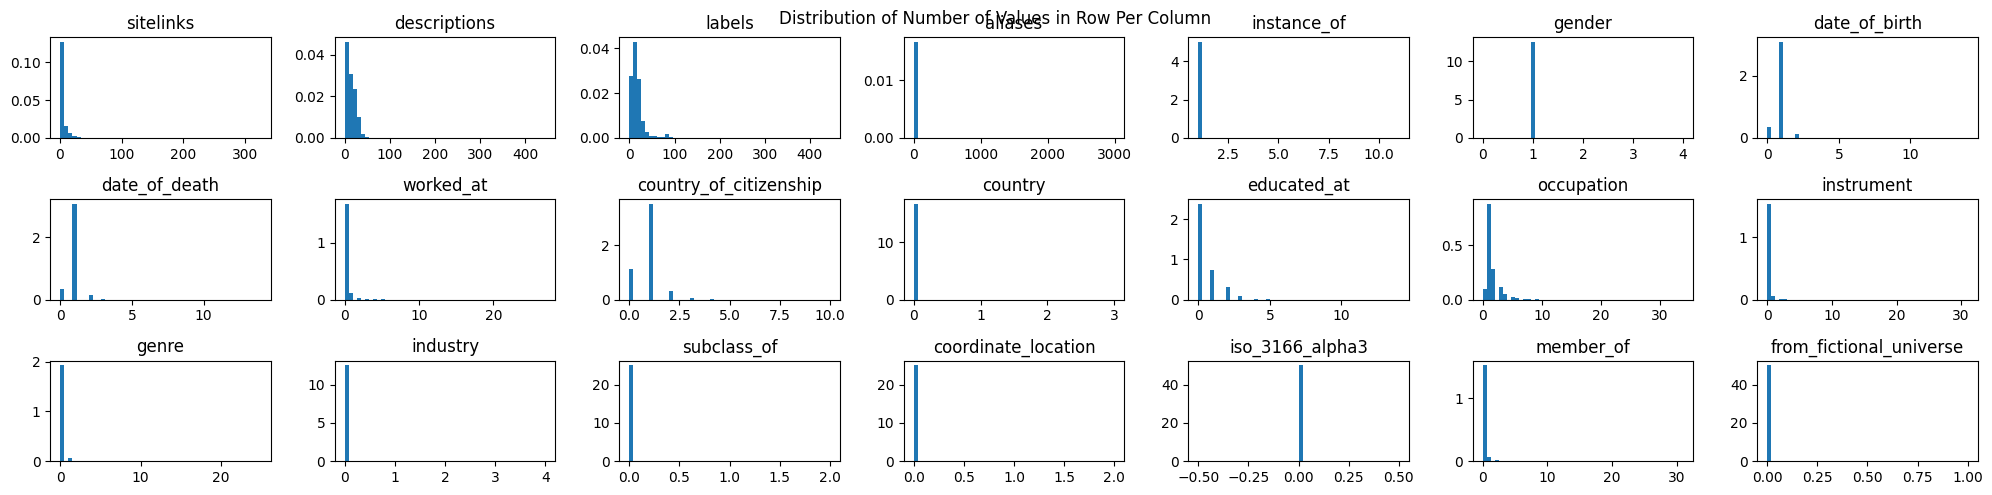

In [24]:
try:
    Image(filename='../figures/num_values_in_row_per_col.png')
except FileNotFoundError:
    fig, axs = plt.subplots(3, 7, figsize=(20, 5))
    for col, ax in zip(list_columns, axs.ravel()):
        ax.hist(info_df[col].map_elements(len), bins=50, density=True)
        ax.set_title(col)
    plt.tight_layout()
    plt.suptitle('Distribution of Number of Values in Row Per Column')
    plt.savefig('../figures/num_values_in_row_per_col.png')
    Image(filename='../figures/num_values_in_row_per_col.png')
    

**Observations:**
There are a few types of columns:
1. Redundant columns: columns that don't add information, either because they contain the same value throughout, have many missing values or do not contribute to our specific needs. The columns are:
    - `type` (same value for all rows)
    - `numeric_id` (contained in `id`)
    - `descriptions` (unneeded information)
    - `labels` (unneeded information)
    - `coordinate_location`(>99% empty)
    - `country` (according to the Wikidata site, this property should not be used for humans)
    - `date_of_death` (has wrong information)

2. Columns with a single value per row: columns that (should) have zero or one values for each row. These columns are:
    - `id`
    - `en_label`
    - `en_wiki`
    - `en_description`
    - `date of birth`

3. Columns with *'interesting'* values per row: columns that contain zero, one or more values for each row, where every (major) value is *interesting* for our purpose. These columns are:
    - `instance_of`
    - `gender` (apparently an entity can have multiple genders)
    - `sitelinks`
    - `instrument`
    - `worked_at`
    - `country_of_citizenship`
    - `educated_at`
    - `occupation`
    - `genre`
    - `industry`
    - `subclass_of`
    - `member_of`
    - `from_fictional_universe`

4. Columns that have multiple values per row: columns that have multiple values per row, where an aggregation of these values is *interesting* for our purposes. These columns are:
    - `sitelinks`
    - `aliases` (We don't care what the aliases *are*, maybe just how many are there)
    - `instrument`
    - `worked_at`
    - `country_of_citizenship`
    - `educated_at`
    - `occupation`
    - `genre`
    - `industry`

 **Note** that a column might be a member of both the third group as well as the fourth group.

Handling strategy for each type of column:
1. Redundant columns --> drop columns.
2. Columns with a single value per row: --> leave as is (flatten if in a list or a struct).
3. Columns with *'interesting'* values per row --> encode into binary columns (bin uncommon values) and drop original.
4. Columns that have multiple values per row --> create a column with the aggregate metric and drop original.


In [46]:
def clean_info_df(df: pl.DataFrame):
    columns_to_drop = ['type', 'descriptions', 'labels', 'iso_3166_alpha3', 'coordinate_location']
    struct_columns = [c for c in df.columns if df[c].dtype == pl.List and c not in columns_to_drop]
    columns_to_encode = [c for c in df.columns if df[c].dtype == pl.List and c not in
                         [*columns_to_drop, 'date_of_birth', 'date_of_death']]
    
    df = (df
          .drop(columns_to_drop) # drop columns
          .with_columns([pl.col(col).list.eval(pl.element().struct[0]) for col in struct_columns]) # unnest structs
    )
    
    unique_sitelinks = df['sitelinks'].explode().unique()
    unique_parents = df['instance_of'].explode().unique()
    unique_
    
    sitelinks_columns = [pl.col('sitelinks').list.contains(site).alias(f'is_in_{site}') for site in unique_sitelinks]
    parents_columns = [pl.col('instance_of').list.contains(parent).alias(f'is_instance_of_{parent}') for parent in unique_parents]
    
    
    df = (df
          .with_columns([
           *sitelinks_columns,
           pl.col('aliases').list.len().alias('num_aliases'),
           *parents_columns,
           
          ]))
    
    return df

clean_info_df(info_df.head(5)).explode('sitelinks').pivot(index='id', )

id,numeric_id,en_label,en_wiki,en_description,sitelinks,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,member_of,from_fictional_universe
str,str,str,str,str,str,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[f64],list[str],list[str]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""dewiki""","[""de"", ""en"", … ""sk""]","[""5""]","[""6581097""]","[""+1901-11-20T00:00:00Z""]","[""+1901-11-20T00:00:00Z""]",[],"[""183""]",[],[],"[""28389"", ""7042855"", ""36180""]",[],[],[],[],[],[],[]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""enwiki""","[""de"", ""en"", … ""sk""]","[""5""]","[""6581097""]","[""+1901-11-20T00:00:00Z""]","[""+1901-11-20T00:00:00Z""]",[],"[""183""]",[],[],"[""28389"", ""7042855"", ""36180""]",[],[],[],[],[],[],[]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""frwiki""","[""de"", ""en"", … ""sk""]","[""5""]","[""6581097""]","[""+1901-11-20T00:00:00Z""]","[""+1901-11-20T00:00:00Z""]",[],"[""183""]",[],[],"[""28389"", ""7042855"", ""36180""]",[],[],[],[],[],[],[]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""arwiki""","[""de"", ""en"", … ""sk""]","[""5""]","[""6581097""]","[""+1901-11-20T00:00:00Z""]","[""+1901-11-20T00:00:00Z""]",[],"[""183""]",[],[],"[""28389"", ""7042855"", ""36180""]",[],[],[],[],[],[],[]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""arzwiki""","[""de"", ""en"", … ""sk""]","[""5""]","[""6581097""]","[""+1901-11-20T00:00:00Z""]","[""+1901-11-20T00:00:00Z""]",[],"[""183""]",[],[],"[""28389"", ""7042855"", ""36180""]",[],[],[],[],[],[],[]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q521785""","""521785""","""Mauro Sérgio V…","""Maurinho_(foot…","""Brazilian foot…","""enwiki""","[""es"", ""es"", … ""fr""]","[""5""]","[""6581097""]","[""+1978-10-11T00:00:00Z""]","[""+1978-10-11T00:00:00Z""]",[],"[""155""]",[],[],"[""937857""]",[],[],[],[],[],[],[]
"""Q521785""","""521785""","""Mauro Sérgio V…","""Maurinho_(foot…","""Brazilian foot…","""arzwiki""","[""es"", ""es"", … ""fr""]","[""5""]","[""6581097""]","[""+1978-10-11T00:00:00Z""]","[""+1978-10-11T00:00:00Z""]",[],"[""155""]",[],[],"[""937857""]",[],[],[],[],[],[],[]
"""Q521785""","""521785""","""Mauro Sérgio V…","""Maurinho_(foot…","""Brazilian foot…","""ptwiki""","[""es"", ""es"", … ""fr""]","[""5""]","[""6581097""]","[""+1978-10-11T00:00:00Z""]","[""+1978-10-11T00:00:00Z""]",[],"[""155""]",[],[],"[""937857""]",[],[],[],[],[],[],[]


In [96]:
info_df.write_parquet(PROCESSED_DATA_DIR / 'wikidata_all.parquet')

Aliases not included in the pageviews data

In [25]:
display(info_df.filter(pl.col('subclass_of').list.len() > 0))

id,numeric_id,en_label,en_wiki,en_description,type,sitelinks,descriptions,labels,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,iso_3166_alpha3,member_of,from_fictional_universe
str,str,str,str,str,str,list[struct[3]],list[struct[2]],list[struct[2]],list[struct[2]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[2]],list[null],list[struct[1]],list[struct[1]]
"""Q6880771""","""6880771""","""Mitarbeiter (N…","""Mitarbeiter_(N…","""contributor in…","""item""","[{""enwiki"",""Mitarbeiter (NSDAP)"",""Mitarbeiter_(NSDAP)""}, {""arwiki"",""ميتابايتر"",""ميتابايتر""}]","[{""de"",""Angestellter der Nazi-Partei im 3. Reich""}, {""en"",""contributor in 3rd Reich Nazi party""}]","[{""en"",""Mitarbeiter (NSDAP)""}, {""es"",""Mitarbeiter""}, … {""de"",""Mitarbeiter (NSDAP)""}]",[],"[{""4189293""}, {""5""}]",[],[],[],"[{""7320""}]",[],[],[],[],[],[],[],"[{""20204892""}]",[],[],[],[]
"""Q1472976""","""1472976""","""Shukr ben Sali…","""Shukr_Kuhayl_I…","""Messiah claima…","""item""","[{""dewiki"",""Shukr Kuhayl I"",""Shukr_Kuhayl_I""}, {""enwiki"",""Shukr Kuhayl I"",""Shukr_Kuhayl_I""}, … {""arwiki"",""شكر كحيل الأول"",""شكر_كحيل_الأول""}]","[{""de"",""jemenitischer Falscher Messias""}, {""en"",""Messiah claimant""}]","[{""de"",""Schukr Kuchayl I.""}, {""en"",""Shukr ben Salim Kuhayl I""}, … {""ga"",""Shukr Kuhayl I""}]","[{""he"",""יהודה בן שלום""}, {""de"",""Shukr ben Salim Kuhayl I""}]","[{""5""}]","[{""6581097""}]","[{""+1821-01-01T00:00:00Z""}]","[{""+1821-01-01T00:00:00Z""}]",[],"[{""805""}]",[],[],[],[],[],[],"[{""116481016""}]",[],[],[],[]
"""Q5506850""","""5506850""","""Fu Style Bagua…","""Fu-style_bagua…","""style of Chine…","""item""","[{""zhwiki"",""傅氏八卦掌"",""傅氏八卦掌""}, {""enwiki"",""Fu-style baguazhang"",""Fu-style_baguazhang""}]","[{""en"",""style of Chinese martial arts""}, {""nl"",""militair""}]","[{""en"",""Fu Style Baguazhang""}, {""es"",""Fu Style Baguazhang""}, … {""sq"",""Fu Style Baguazhang""}]","[{""en"",""Fu Style Wudang Fist""}]","[{""5""}]","[{""6581097""}]","[{""+1872-01-01T00:00:00Z""}]","[{""+1872-01-01T00:00:00Z""}]",[],[],[],[],"[{""47064""}]",[],[],[],"[{""800177""}]",[],[],[],[]
"""Q109491354""","""109491354""","""Vladimir Aleks…","""Vladimir_Aleks…","""Russian lieute…","""item""","[{""ruwiki"",""Алексеев, Владимир Степанович"",""Алексеев,_Владимир_Степанович""}, {""plwiki"",""Władimir Aleksiejew (generał)"",""Władimir_Aleksiejew_(generał)""}, … {""ukwiki"",""Алексєєв Володимир Степанович"",""Алексєєв_Володимир_Степанович""}]","[{""ru"",""первый заместитель начальника ГРУ ГШ ВС РФ""}, {""ast"",""militar rusu""}, … {""en"",""Russian lieutenant general""}]","[{""ru"",""Алексеев, Владимир Степанович""}, {""pl"",""Władimir Aleksiejew""}, … {""de"",""Wladimir Stepanowitsch Aleksejew""}]","[{""zh"",""弗拉基米尔·斯捷潘诺维奇·阿列克谢耶夫""}, {""en"",""Vladimir Stepanovich Alekseyev""}]","[{""5""}]","[{""6581097""}]","[{""+1961-04-24T00:00:00Z""}, {""+1961-04-23T00:00:00Z""}, {""+1964-04-24T00:00:00Z""}]","[{""+1961-04-24T00:00:00Z""}, {""+1961-04-23T00:00:00Z""}, {""+1964-04-24T00:00:00Z""}]",[],"[{""15180""}, {""159""}]","[{""159""}]","[{""1968714""}]","[{""47064""}]",[],[],[],"[{""11075015""}]",[],[],[],[]
"""Q5176774""","""5176774""","""Count of Pardi…","""Count_of_Pardi…","""title in Frenc…","""item""","[{""enwiki"",""Count of Pardiac"",""Count_of_Pardiac""}, {""frwiki"",""Comte de Pardiac"",""Comte_de_Pardiac""}, … {""eswiki"",""Conde de Pardiac"",""Conde_de_Pardiac""}]","[{""en"",""title in French nobility""}, {""fr"",""titre de noblesse français""}, {""tr"",""Fransız soyluluk unvanı""}]","[{""en"",""Count of Pardiac""}, {""nl"",""Count of Pardiac""}, … {""tr"",""Pardiac Kontu""}]","[{""en"",""count of Pardiac""}, {""en"",""countess 

In [60]:
(info_df['numeric_id'] == info_df['id'].str.replace('Q', '')).all()

True

### Additional Features Extraction

Convert code to label description:
- https://stackoverflow.com/questions/59737076/how-to-get-a-label-of-a-property-from-wikidata
- https://stackoverflow.com/questions/72704205/how-to-convert-wiki-data-qid-to-entity-and-vice-versa-in-python

In [ ]:
info_df.filter(info_df['en_description'].str.starts_with('fictional'))

id,numeric_id,en_label,en_wiki,en_description,type,sitelinks,descriptions,labels,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,iso_3166_alpha3,member_of,from_fictional_universe
str,str,str,str,str,str,list[struct[3]],list[struct[2]],list[struct[2]],list[struct[2]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[2]],list[null],list[struct[1]],list[struct[1]]
"""Q16209139""","""16209139""","""Norman Gunston…","""Norman_Gunston…","""fictional char…","""item""","[{""enwiki"",""Norman Gunston"",""Norman_Gunston""}]","[{""nl"",""zanger""}, {""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Norman Gunston""}, {""de"",""Norman Gunston""}, … {""sq"",""Norman Gunston""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],"[{""177220""}]","[{""17172850""}]",[],[],[],[],[],[],[]
"""Q121026451""","""121026451""","""Mae Paner""","""Mae_Paner""","""fictional char…","""item""","[{""enwiki"",""Mae Paner"",""Mae_Paner""}]","[{""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Mae Paner""}, {""de"",""Mae Paner""}, … {""pt-br"",""Mae Paner""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],"[{""2259451""}, {""1476215""}]",[],[],[],[],[],[],[],[]
"""Q5460334""","""5460334""","""Flora Malherbe…","""Flora_Malherbe…","""fictional char…","""item""","[{""enwiki"",""Flora Malherbe"",""Flora_Malherbe""}]","[{""nl"",""monteur""}, {""en"",""fictional character on the American TV sitcom The Andy Griffith Show and its successor, Mayberry RFD""}]","[{""en"",""Flora Malherbe""}, {""es"",""Flora Malherbe""}, {""ast"",""Flora Malherbe""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],"[{""327029""}]",[],[],[],[],[],[],[],[]
"""Q4751616""","""4751616""","""Anaranya""","""Anaranya""","""fictional char…","""item""","[{""enwiki"",""Anaranya"",""Anaranya""}, {""ptwiki"",""Anaranya"",""Anaranya""}, … {""ruwiki"",""Анаранья"",""Анаранья""}]","[{""bn"",""হিন্দু পৌরাণিক চরিত্র""}, {""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Anaranya""}, {""pt"",""Anaranya""}, … {""ru"",""Анаранья""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q7844223""","""7844223""","""Tristram the Y…","""Tristan_the_Yo…","""fictional char…","""item""","[{""enwiki"",""Tristan the Younger"",""Tristan_the_Younger""}]","[{""en"",""fictional character in Arthurian romances""}]","[{""en"",""Tristram the Younger""}, {""ast"",""Tristram the Younger""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q7174933""","""7174933""","""Peter Jairus F…","""Peter_Jairus_F…","""fictionalized …","""item""","[{""enwiki"",""Peter Jairus Frigate"",""Peter_Jairus_Frigate""}]","[{""en"",""fictionalized version of the science fiction author Philip José Farmer in Riverworld series""}]","[{""en"",""Peter Jairus Frigate""}, {""de"",""Peter Jairus Frigate""}, … {""ast"",""Peter Jairus Frigate""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q26409637""","""26409637""","""Amy Teo""","""Amy_Teo""","""fictional char…","""item""","[{""enwiki"",""Amy Teo"",""Amy_Teo""}]","[{""en"",""fictional character from the BBC medical drama Holby City""}]","[{""en"",""Amy Teo""}, {""nl"",""Amy Teo""}, … {""ast"",""Amy Teo""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q10788162""","""10788162""","""Lý Ông Trọng""","""Ruan_Wengzhong…","""fictional char…","""item""","[{""viwiki"",""Lý Ông Trọng"",""Lý_Ông_Trọng""}, {""zhwiki"",""阮翁仲"",""阮翁仲""}, … {""thwiki"",""รฺเหวี่ยน เวิงจ้ง"",""รฺเหวี่ยน_เวิงจ้ง""}]","[{""en"",""fictional character""}, {""vi"",""

# Time Series Clustering

In [ ]:
views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')

In [98]:
views_df[:30]

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
"""Carolyn_Stanfo…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,221,294,359,286,650,202,170,169,83,97,107,112,70,78,88,64,54,78,84,74,131,74,86,180,105,75,76,73,105,56,50,89,86,59,58,50,42
"""Boncho_Novakov…",16,18,26,19,21,16,11,14,18,6,6,15,4,10,10,15,14,12,11,18,14,4,22,13,15,16,8,13,11,8,7,14,18,9,7,11,…,4,7,5,3,18,39,5,3,5,5,2,4,5,3,5,5,4,6,7,3,4,5,5,5,3,9,2,3,4,4,3,7,9,2,3,2,3
"""Margaret_Hodge…",5665,2932,2420,2482,3097,2693,1955,1867,3365,2059,1808,3435,4174,12893,4331,4311,3434,2573,2110,1829,1813,1953,1667,2523,2442,3777,1705,1577,5159,1650,3699,1623,2057,1368,2277,2749,…,2260,1819,2069,1605,1630,1890,2082,1391,1126,1351,2217,1430,4400,1788,2612,1680,1471,1743,1336,2097,1272,1918,2196,1194,1204,1536,2234,1909,1311,1261,3170,2097,1026,1335,5767,2327,3310
"""Carmen_Belén_R…",null,null,null,null,null,25,26,31,27,60,35,32,29,20,20,51,23,31,37,31,59,46,51,35,28,31,34,34,25,42,27,39,118,56,36,46,…,17,24,56,80,25,32,31,13,24,25,18,27,27,18,46,54,20,24,30,12,14,12,25,27,10,31,36,63,29,12,10,15,36,20,15,20,17


In [118]:
X_train = views_df.select([col for col in views_df.columns if col != 'title']).fill_null(0).to_numpy()
X_train

array([[ 0,  0,  0, ..., 44, 23, 25],
       [26, 34, 52, ..., 59, 41, 19],
       [ 9, 48, 24, ..., 10,  1,  5],
       ...,
       [40, 29, 34, ...,  3,  1,  2],
       [23, 52, 38, ...,  8,  7,  6],
       [ 0,  0,  0, ..., 16,  8,  7]])

In [119]:
X_train.shape

(1976658, 104)

In [120]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)

sz = X_train.shape[1]

X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed,
n_jobs=-1)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed,
                          n_jobs=-1)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")


plt.tight_layout()
plt.show()

Euclidean k-means

143.854 --> 76.592 --> 

KeyboardInterrupt: 

In [112]:
km.inertia_

70.60124743054607

In [114]:
y_pred

array([2, 1, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1,
       2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 2,
       2, 2, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2])

In [115]:
y = views_df[:100].with_columns(pl.Series(name='cluster', values=y_pred))

https://github.com/aeon-toolkit/aeon/blob/4a58c4dba5bb37e43979368ad9cf092540e71786/examples/segmentation/segmentation_with_clasp.ipynb